# CO2 Group - Version 1 Final
OOI Data Labs Workshop - July 2019

Revised 11/12/19

**Working Title**: CO2 exchange between air and sea (Application phase)

**Short Description**: 
* Exploration: Explore factors that control the concentration of CO2 in the ocean and exchanges of CO2 between the ocean and atmosphere
* Application: Evaluate whether a mystery site is a source or a sink of CO2, discuss the environmental factors that determine this, and predict the location of the mystery site by comparing to known regions

In [67]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import datetime 

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet


* **Time range:** 2018-01-01 00:00:00 to 2019-11-01 00:00:00
* **Variables:** PCO2 Air/Water, Seawater Temperature, Salinity, Wind Speed, Chlorophyll
* **Instruments** recovered_host pco2a_a_dcl_instrument_air_recovered or pco2a_a_dcl_instrument_water_recovered
  * CE07SHSM-SBD12-04-PCO2AA000 Washington Shelf Surface Mooring
  * CP03ISSM-SBD12-04-PCO2AA000 Pioneer Inshore Surface Mooring
  * CE02SHSM-SBD12-04-PCO2AA000 Oregon Shelf Surface Mooring

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# request_data('CE07SHSM-SBD12-04-PCO2AA000','recovered_host','pco2a_a_dcl_instrument_air_recovered',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD12-04-PCO2AA000','telemetered','pco2a_a_dcl_instrument_air',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('CE02SHSM-SBD12-04-PCO2AA000','recovered_host','pco2a_a_dcl_instrument_air_recovered',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')

# We need met data form CP to manually calculate flux
# request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')

# Fluorometer Data
# request_data('CE07SHSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('CP03ISSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('CE02SHSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2018-01-01T00:00:00.000Z','2019-11-01T00:00:00.000Z')


## 2. Load Data Files

In [0]:
url_ce07 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191105T191944028Z-CE07SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
url_cp03 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191105T212934406Z-CP03ISSM-SBD12-04-PCO2AA000-telemetered-pco2a_a_dcl_instrument_air/catalog.html'
url_ce02 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191105T204439704Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
url_cp03_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191107T203620515Z-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'
url_ce07_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191107T203835121Z-CE07SHSM-RID27-02-FLORTD000-recovered_host-flort_sample/catalog.html'
url_cp03_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191107T203909618Z-CP03ISSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_ce02_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191107T203919943Z-CE02SHSM-RID27-02-FLORTD000-recovered_host-flort_sample/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d)
  selected_datasets = sorted(selected_datasets)
  if 'CE07SHSM' in url:
    selected_datasets = selected_datasets[1:]
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
data_ce07 = get_data(url_ce07)
data_ce07['pco2_co2flux'] = data_ce07['pco2_co2flux'] *1e6 *-1 #Reverse flux bug
data_ce07['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

In [0]:
data_cp03 = get_data(url_cp03)
data_cp03['pco2_co2flux'] = data_cp03['pco2_co2flux'] *1e6 *-1 #Reverse flux bug
data_cp03['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

In [0]:
data_ce02 = get_data(url_ce02)
data_ce02['pco2_co2flux'] = data_ce02['pco2_co2flux'] *1e6 *-1 #Reverse flux bug
data_ce02['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

## A little bit of cleaning

In [0]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
data_ce07['partial_pressure_co2_atm'] = data_ce07['partial_pressure_co2_atm'].where(reject_outliers(data_ce07['partial_pressure_co2_atm']))
data_ce07['pco2_co2flux'] = data_ce07['pco2_co2flux'].where(reject_outliers(data_ce07['pco2_co2flux']))

# Run twice
data_ce02['partial_pressure_co2_atm'] = data_ce02['partial_pressure_co2_atm'].where(reject_outliers(data_ce02['partial_pressure_co2_atm']))
data_ce02['partial_pressure_co2_ssw'] = data_ce02['partial_pressure_co2_ssw'].where(reject_outliers(data_ce02['partial_pressure_co2_ssw']))
data_ce02['partial_pressure_co2_atm'] = data_ce02['partial_pressure_co2_atm'].where(reject_outliers(data_ce02['partial_pressure_co2_atm']))
data_ce02['partial_pressure_co2_ssw'] = data_ce02['partial_pressure_co2_ssw'].where(reject_outliers(data_ce02['partial_pressure_co2_ssw']))
data_ce02['pco2_co2flux'] = data_ce02['pco2_co2flux'].where(reject_outliers(data_ce02['pco2_co2flux']))
data_ce02['partial_pressure_co2_atm'] = data_ce02['partial_pressure_co2_atm'].where((data_ce02['partial_pressure_co2_atm']>100) & (data_ce02['partial_pressure_co2_atm']<500))
data_ce02['partial_pressure_co2_ssw'] = data_ce02['partial_pressure_co2_ssw'].where((data_ce02['partial_pressure_co2_ssw']>100) & (data_ce02['partial_pressure_co2_ssw']<500))


## 3. Plotting Fun

In [0]:
def plot_data(d,name='fig'):
  fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
  avgint='4D'
  timeshift = 2

  data = d.to_dataframe()
  # FIGURE 1 = CO2 in ATMOSPHERE AND OCEANS
  data.partial_pressure_co2_atm.plot(ax=ax1,label='Atmosphere',linestyle='None',marker='.',markersize=1,color='w')
  data.partial_pressure_co2_ssw.plot(ax=ax1,label='Seawater',linestyle='None',marker='.',markersize=1,color='w')
  data.partial_pressure_co2_atm.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax1,label='Atmosphere Avg')
  data.partial_pressure_co2_ssw.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax1,label='Seawater Avg')
  # ax1.set_ylim([180,580]);
  # ax1.set_ylabel('Air and Water CO2 (uatm)')
  ax1.set_ylabel('{} ({})'.format('pCO2', d.partial_pressure_co2_atm.units),fontsize=8)
  ax1.legend();

  # # FIGURE 2 = CO2 FLUX
  data.pco2_co2flux.plot(ax=ax2,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
  data.pco2_co2flux.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax2,color='c',label='Avg')
  # ax2.set_ylim([-20,10])
  # ax2.set_ylabel('CO2 flux (mmol m^-2 d^-1)')
  ax2.set_ylabel('{} ({})'.format('CO2 Flux from Ocean', d.pco2_co2flux.units),fontsize=8)
  ax2.legend();

  # FIGURE 3 = WIND SPEED
  data.met_wind10m.plot(ax=ax3,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
  data.met_wind10m.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax3,color='b',label='Avg')
  ax3.set_ylim([2,10])
  # ax3.set_ylabel('Wind Speed (m/s)')
  ax3.set_ylabel('{} ({})'.format('Wind Velocity at 10 M', 'm/s'),fontsize=8)
  ax3.legend();

  # FIGURE 4 = SEA SURFACE TEMP
  data.sea_surface_temperature.plot(ax=ax4,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
  data.sea_surface_temperature.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax4,color='r',label='Avg')
  # ax4.set_ylim([1.5,12])
  # ax4.set_ylabel('Sea Surface Temp (C)')
  ax4.set_ylabel('{} ({})'.format('Temperature', d.sea_surface_temperature.units),fontsize=8)
  ax4.legend();

  # FIGURE 5 = Salinity
  data.met_salsurf.plot(ax=ax5,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
  data.met_salsurf.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax5,color='g',label='Avg')
  # ax5.set_ylim([1.5,12])
  # ax5.set_ylabel('Sea Surface Temp (C)')
  ax5.set_ylabel('{} ({})'.format('Salinity', d.met_salsurf.units),fontsize=8)
  ax5.legend();

  ax1.set_title(name);
  plt.savefig(name+'.png')

/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


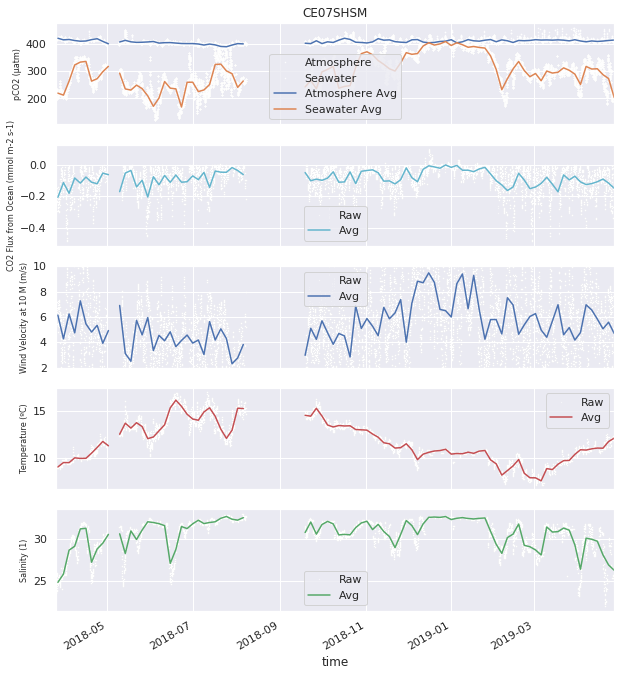

In [78]:
plot_data(data_ce07,'CE07SHSM')

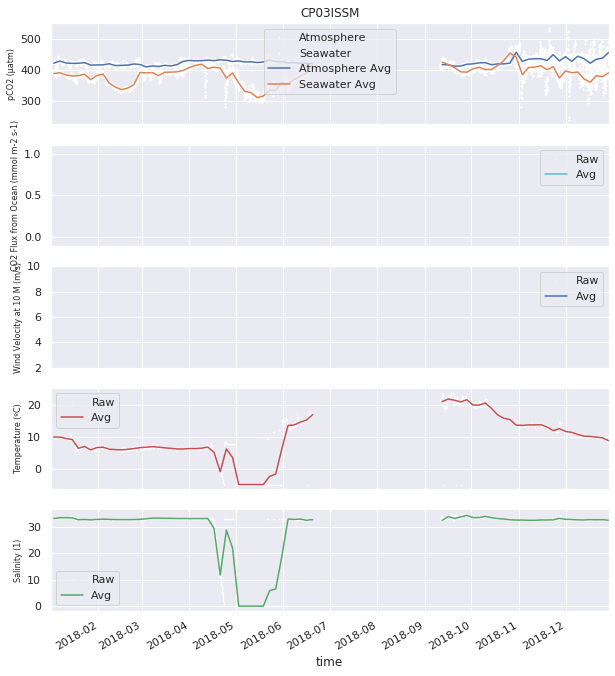

In [79]:
plot_data(data_cp03,'CP03ISSM')

/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


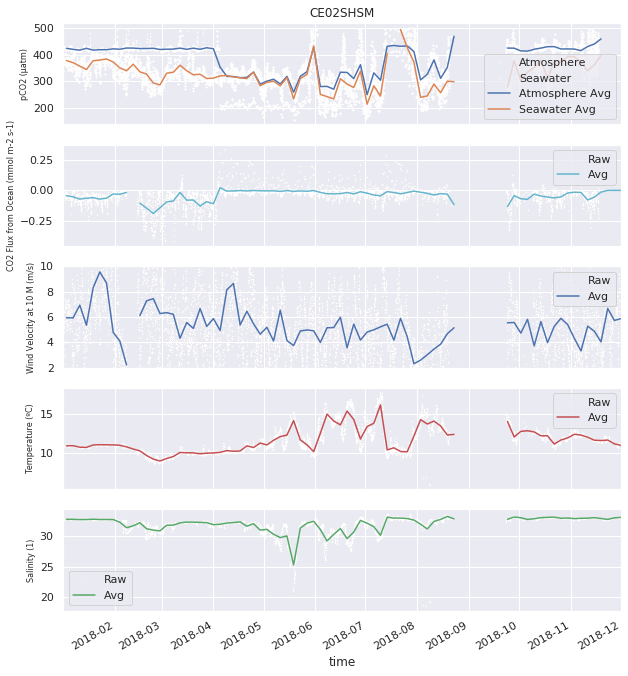

In [80]:
plot_data(data_ce02,'CE02SHSM')

## Manual Flux Calculation

Aparently, Pioneer doesn't have flux included, so we need to calculate it manually.  

We can use the following [OOI ion-function](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/co2_functions.py) to do so.  For the purposes of this notebook, I manually added an edited file to Google Colab.

Note, while researching this, we discoverd that the flux outputted by the system in the netcdf files is reversed.  Thus, I've reversed the flux above (multiplying by -1).  The flux as outputted by the function itself is correct.

In [0]:
import pco2_co2flux

In [0]:
# First, let's test the function on CE07
f = pco2_co2flux.pco2_co2flux(data_ce07.partial_pressure_co2_ssw,
                          data_ce07.partial_pressure_co2_atm,
                          data_ce07.met_wind10m,
                          data_ce07.sea_surface_temperature,
                          data_ce07.met_salsurf) * 1e6

/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


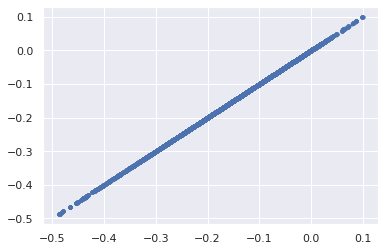

In [83]:
# Comparison
plt.plot(f,data_ce07.pco2_co2flux,'.');

In [84]:
# Ok, so now let's load the Pioneer Met Data
data_cp03_met = get_data(url_cp03_met)

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [0]:
# Average and merge datasets
d1 = data_cp03.to_dataframe().resample('1H').mean()
d1 = d1[['partial_pressure_co2_atm','partial_pressure_co2_ssw']]
d2 = data_cp03_met.to_dataframe().resample('1H').mean()
d2 = d2[['sea_surface_temperature','met_salsurf','met_relwind_speed']]
cp03 = d1.combine_first(d2)

In [0]:
cp03[cp03['sea_surface_temperature']<0] = np.nan
cp03[cp03['met_salsurf']<20] = np.nan

In [0]:
# Calculate Pioneer Flux
cp03['pco2_co2flux'] = pco2_co2flux.pco2_co2flux(cp03.partial_pressure_co2_ssw,
                          cp03.partial_pressure_co2_atm,
                          cp03.met_relwind_speed,
                          cp03.sea_surface_temperature,
                          cp03.met_salsurf) *1e6

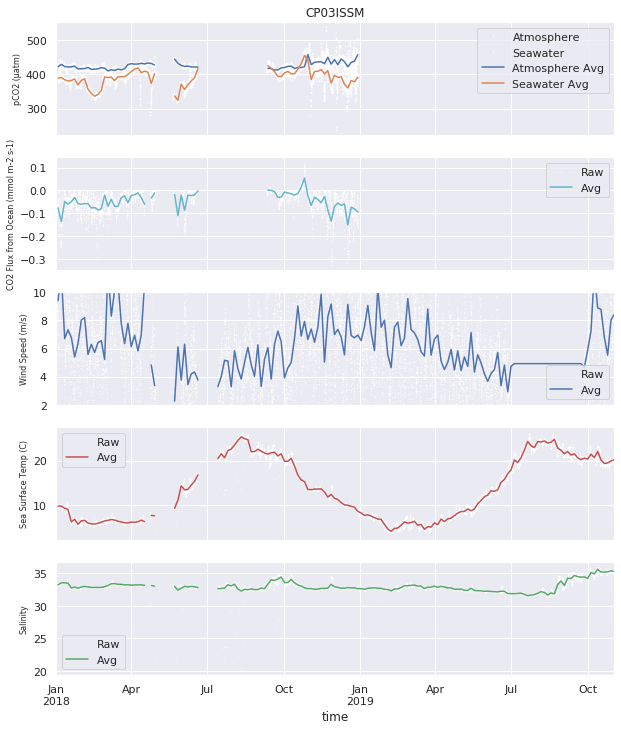

In [88]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
avgint='4D'
timeshift = 2

# FIGURE 1 = CO2 in ATMOSPHERE AND OCEANS
cp03.partial_pressure_co2_atm.plot(ax=ax1,label='Atmosphere',linestyle='None',marker='.',markersize=1,color='w')
cp03.partial_pressure_co2_ssw.plot(ax=ax1,label='Seawater',linestyle='None',marker='.',markersize=1,color='w')
cp03.partial_pressure_co2_atm.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax1,label='Atmosphere Avg')
cp03.partial_pressure_co2_ssw.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax1,label='Seawater Avg')
ax1.set_ylabel('pCO2 (µatm)',fontsize=8)
ax1.legend();

# # FIGURE 2 = CO2 FLUX
cp03.pco2_co2flux.plot(ax=ax2,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
cp03.pco2_co2flux.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax2,color='c',label='Avg')
ax2.set_ylabel('CO2 Flux from Ocean (mmol m-2 s-1)',fontsize=8)
ax2.legend();

# FIGURE 3 = WIND SPEED
cp03.met_relwind_speed.plot(ax=ax3,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
cp03.met_relwind_speed.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax3,color='b',label='Avg')
ax3.set_ylim([2,10])
ax3.set_ylabel('Wind Speed (m/s)',fontsize=8)
ax3.legend();

# FIGURE 4 = SEA SURFACE TEMP
cp03.sea_surface_temperature.plot(ax=ax4,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
cp03.sea_surface_temperature.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax4,color='r',label='Avg')
ax4.set_ylabel('Sea Surface Temp (C)',fontsize=8)
ax4.legend();

# FIGURE 5 = Salinity
cp03.met_salsurf.plot(ax=ax5,linestyle='None',marker='.',markersize=0.5,color='w',label='Raw')
cp03.met_salsurf.resample(avgint).mean().tshift(timeshift,freq='D').plot(ax=ax5,color='g',label='Avg')
ax5.set_ylabel('Salinity',fontsize=8)
ax5.legend();

ax1.set_title('CP03ISSM')
plt.savefig('CP03_revised.png')

## 4. Merge and export

In [89]:
avgint='1H'

a = data_ce07.to_dataframe().resample(avgint).mean()
a = a[['partial_pressure_co2_atm','partial_pressure_co2_ssw','pco2_co2flux','sea_surface_temperature','met_salsurf','met_relwind_speed']]
a.loc[datetime.datetime(2018,1,1)] = np.nan # Add row to hopefully fix averaging offset
a = a.sort_index()

b = data_ce02.to_dataframe().resample(avgint).mean()
b = b[['partial_pressure_co2_atm','partial_pressure_co2_ssw','pco2_co2flux','sea_surface_temperature','met_salsurf','met_relwind_speed']]

c = cp03.resample(avgint).mean()

a = a.rename(columns={'partial_pressure_co2_atm':'CE07 pCO2 Atm',
          'partial_pressure_co2_ssw':'CE07 pCO2 Sea',
          'pco2_co2flux':'CE07 CO2 Flux',
          'sea_surface_temperature':'CE07 SST',
          'met_salsurf':'CE07 Sal',
          'met_relwind_speed':'CE07 Wind'})
b = b.rename(columns={'partial_pressure_co2_atm':'CE02 pCO2 Atm',
          'partial_pressure_co2_ssw':'CE02 pCO2 Sea',
          'pco2_co2flux':'CE02 CO2 Flux',
          'sea_surface_temperature':'CE02 SST',
          'met_salsurf':'CE02 Sal',
          'met_relwind_speed':'CE02 Wind'})
c = c.rename(columns={'partial_pressure_co2_atm':'CP03 pCO2 Atm',
          'partial_pressure_co2_ssw':'CP03 pCO2 Sea',
          'pco2_co2flux':'CP03 CO2 Flux',
          'sea_surface_temperature':'CP03 SST',
          'met_salsurf':'CP03 Sal',
          'met_relwind_speed':'CP03 Wind'})


/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/usr/local/lib/python3.6/dist-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [90]:
# x = a.combine_first(b).combine_first(c) #Does not align times properly
x = a.merge(b,on='time',how='outer').merge(c,on='time',how='outer')
x = x.resample('4D').mean().tshift(2,freq='D')
x = x.dropna(how='all')
x.sample(5)

,CE07 pCO2 Atm,CE07 pCO2 Sea,CE07 CO2 Flux,CE07 SST,CE07 Sal,CE07 Wind,CE02 pCO2 Atm,CE02 pCO2 Sea,CE02 CO2 Flux,CE02 SST,CE02 Sal,CE02 Wind,CP03 Wind,CP03 Sal,CP03 pCO2 Atm,CP03 pCO2 Sea,CP03 SST,CP03 CO2 Flux
time,,,,,,,,,,,,,,,,,,
2018-11-03,404.040984,375.030134,-0.031159,12.888032,32.091220,5.649331,420.707341,392.477865,-0.014733,12.424146,32.812830,3.969484,7.386409,32.664827,427.377828,384.160653,13.508504,-0.065949
2019-02-27,414.247453,283.721275,-0.176413,8.001021,29.341364,6.482774,NaN,NaN,NaN,NaN,NaN,NaN,9.558469,33.113173,NaN,NaN,6.057709,NaN
2018-08-19,NaN,NaN,NaN,NaN,NaN,NaN,352.135826,300.900792,-0.030881,12.331371,33.178111,4.213501,6.084910,32.486454,NaN,NaN,24.675585,NaN
2019-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.978101,32.322576,NaN,NaN,11.088353,NaN
2019-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.438911,32.578322,NaN,NaN,8.623285,NaN


In [0]:
# Export to CSV
x.to_csv('CO2_data.csv')

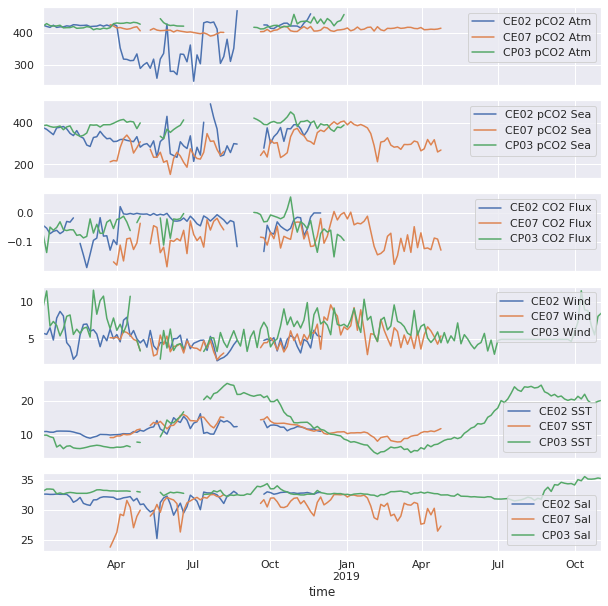

In [92]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,sharex=True,figsize=(10,10))
x[['CE02 pCO2 Atm','CE07 pCO2 Atm','CP03 pCO2 Atm']].plot(ax=ax1)
x[['CE02 pCO2 Sea','CE07 pCO2 Sea','CP03 pCO2 Sea']].plot(ax=ax2)
x[['CE02 CO2 Flux','CE07 CO2 Flux','CP03 CO2 Flux']].plot(ax=ax3)
x[['CE02 Wind','CE07 Wind','CP03 Wind']].plot(ax=ax4)
x[['CE02 SST','CE07 SST','CP03 SST']].plot(ax=ax5)
x[['CE02 Sal','CE07 Sal','CP03 Sal']].plot(ax=ax6)
plt.savefig('CO2_final.png')

## Questions
* There are a variety of other [PCO2A instruments](https://datareview.marine.rutgers.edu/instrument-models/view/PCO2A/A) available 
* For CP03ISSM I had to use telemetered because the wind data isn't available in the recovered stream.
* Did you want to use the same time range for all 3 locations?
* It sounds like you wantd to include both CE and CP in the Exploration, along with all of their variables.  Should we split up the activity a bit more? Perhaps:
  * Exploration: CE Air/Sea CO2 and Flux (2 graphs)
  * Exploration: CE Air/Sea CO2 and Flux with other measurements (3 graphs)
  * Concept Invention: Air/Sea CO2 and Flux at CE and CP (2 graphs?)
  * Application: Introduce 3rd mystery site, along with Air/Sea CO2 and Flux at CE and CP
* It looks like CP03ISSM does not have wind data for 2018 onwards (not sure why). We could manually calculate flux using another wind sensor.
* Are the flux signs correct?